In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

### Load Dataset and Select Ticker

In [46]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
df = stock_df[stock_filt]
window = 30
df = clean_stock_data(df, window)
df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


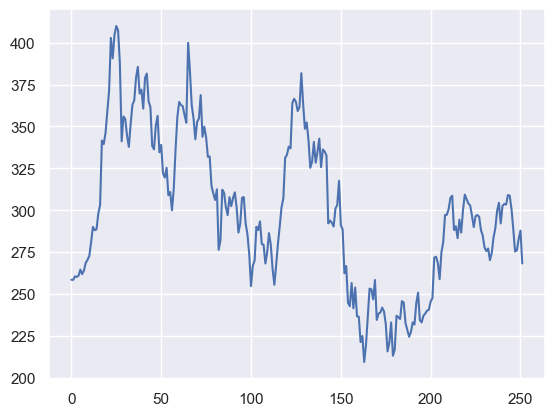

In [47]:
plt.plot(df['close'].values)

### Generate Useful Features

In [65]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145


Text(0.5, 1.0, 'Normalized Closing Price Using Accumulated % Changes')

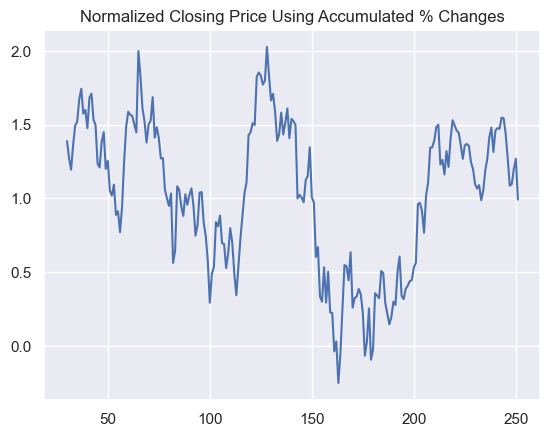

In [66]:
plt.plot(features['close'])
plt.title('Normalized Closing Price Using Accumulated % Changes')

### Generate GRU train and test split

In [67]:
target = 0 #predict closing percent delta
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (201, 20, 13)
> Data y: (201, 1)
Train Set
> Data X: (171, 20, 13)
> Data y: (171, 1)
Test Set
> Data X: (30, 20, 13)
> Data y: (30, 1)


### Define Model

In [69]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [75]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.6169  


In [76]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=14,
    batch_size=128
)

Epoch 1/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 19.8464 - val_loss: 16.0102
Epoch 2/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 20.0446 - val_loss: 15.3528
Epoch 3/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 19.7065 - val_loss: 15.0206
Epoch 4/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 19.6970 - val_loss: 14.8966
Epoch 5/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 19.7230 - val_loss: 14.8874
Epoch 6/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 19.7024 - val_loss: 14.9554
Epoch 7/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 19.6490 - val_loss: 15.0969
Epoch 8/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 19.5975 - val_loss: 15.2762
Epoch 9/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 19.5861 - val_loss: 15.2886
Epoch 10/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 19.5583 - val_loss: 15.0900
Epoch 11/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 19.4763 - val_loss: 14.8259
Epoch 12/14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 19.4140

### Plot Performance

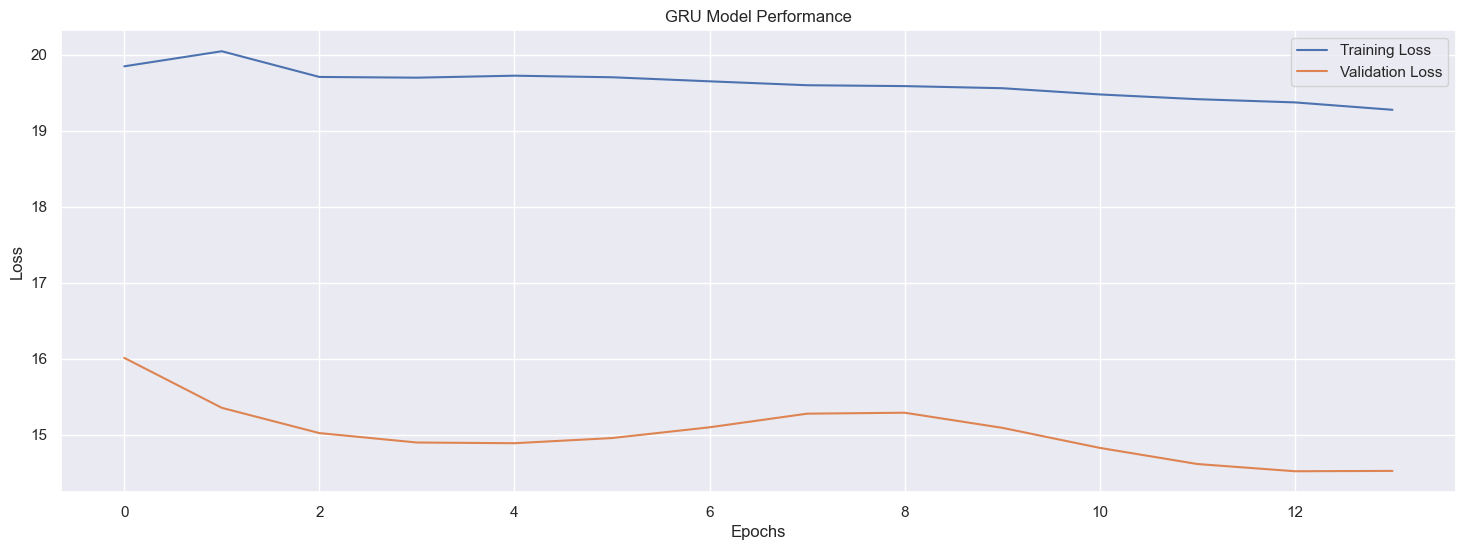

In [83]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [84]:
history.history['val_loss']

[16.010190963745117,
 15.35284423828125,
 15.020557403564453,
 14.896646499633789,
 14.887435913085938,
 14.955377578735352,
 15.096932411193848,
 15.27624797821045,
 15.288567543029785,
 15.0899658203125,
 14.825852394104004,
 14.613646507263184,
 14.518548965454102,
 14.523056030273438]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


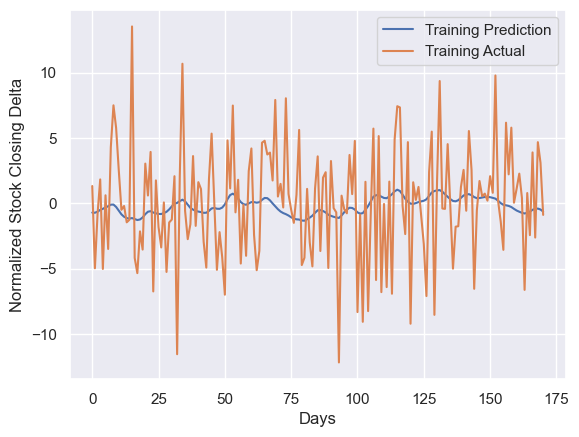

In [91]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [102]:
diff = np.sign(train_predictions.flatten())-np.sign(train_actual.flatten())
thresh = np.max(np.abs(train_predictions))/2
significant = np.where(np.abs(train_predictions.flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')
num_wrong = np.count_nonzero(diff)
err = num_wrong/len(diff)
print('Overall Error Rate: ' + str(err*100) + '%')

We perform predictions for 171 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 0.66839814
There are 60 such events
Of those events, we predict 22 incorrectly
Overall Error Rate: 47.368421052631575%


The accumulated % deltas clearly are not effective for predicting closing price


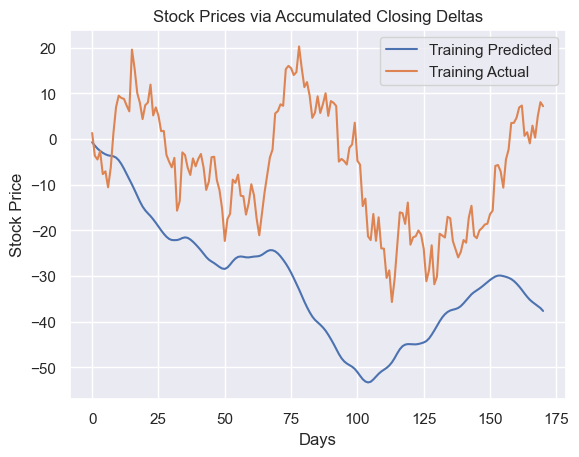

In [105]:
stock_price_train_pred = np.cumsum(train_predictions)
stock_price_train_actual = np.cumsum(train_actual)
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
print('The accumulated % deltas clearly are not effective for predicting closing price')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


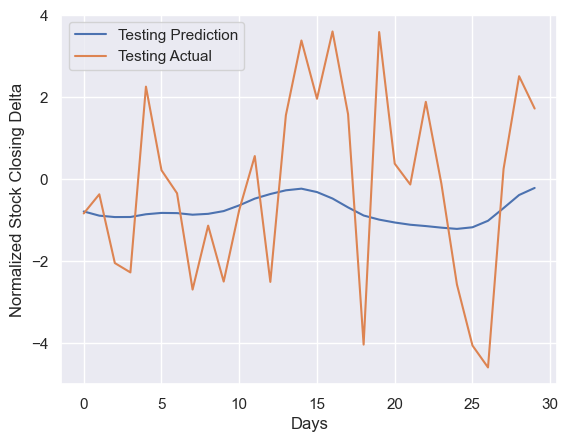

In [106]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

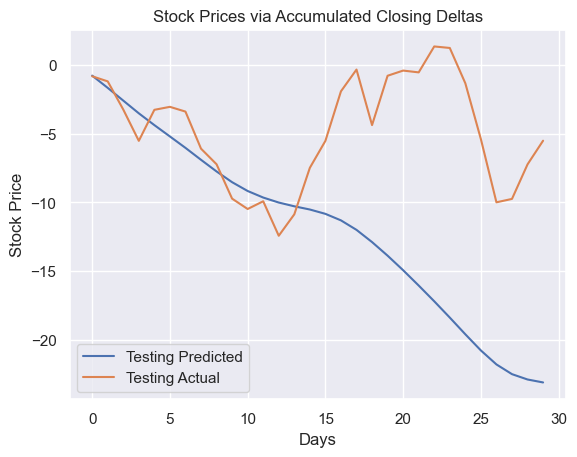

In [107]:
stock_price_test_pred = np.cumsum(test_predictions)
stock_price_test_actual = np.cumsum(test_actual)
plt.plot(stock_price_test_pred, label='Testing Predicted')
plt.plot(stock_price_test_actual, label='Testing Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()